# World Values Survey Data Work Notebook - Child Traits

In [127]:
# Standard
import numpy as np
import pandas as pd
import pickle

# Create combinations
from itertools import combinations

# Read RData files
import pyreadr

# Graph construction
import networkx as nx

# Visualizations
import matplotlib.pyplot as plt
import plotly.graph_objects as go


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## Acquiring Data
The data was acquired from the World Values Survey at https://www.worldvaluessurvey.org/wvs.jsp. Wave 1 through 6 were in .rds format while Wave 7 was in .rdata format.

In [ ]:
# Use pyreadr to read .rds files to DataFrame
wv1_6 = [ pyreadr.read_r(f'../rdata/wv{i}.rds')[None] for i in range(1, 7) ]

In [2]:
# RData converted from .rdata file to CSV with RStudio
wv7 = pd.read_csv('../rdata/wv7.csv', index_col=0)

/Users/waynelam/Projects/world_values/wv-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (517,518,519) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Traits that should be encouraged in children (Wave 7, Q7-17)
- List of Traits (choose 5): good manners, independence, hard work, feeling of responsibility, imagination, tolerance and respect for other people, thrift/saving money, determination/perseverance, religious faith, not being selfish, obedience

In [81]:
df = wv7[['B_COUNTRY_ALPHA', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17']].copy()

In [82]:
# Create dictionary from questionnaire
traits_dict = {
    'B_COUNTRY_ALPHA': 'country',
    'Q7': 'manners',
    'Q8': 'independence',
    'Q9': 'hard work',
    'Q10': 'responsibility',
    'Q11': 'imagination',
    'Q12': 'tolerance',
    'Q13': 'thrift',
    'Q14': 'determination',
    'Q15': 'faith',
    'Q16': 'unselfishness',
    'Q17': 'obedience',
}

# Function to boolean
def convert_bool(x):
    if x == 1:
        return True
    else:
        return False

In [83]:
# Clean column names and convert to boolean
df.columns = df.columns.map(traits_dict)
df.iloc[:, 1:] = df.iloc[:, 1:].applymap(convert_bool)

In [84]:
# Create list of traits
traits = [ col for col in df.columns if col != 'country' ]

In [85]:
# Create column of number of traits
df['num'] = df[traits].sum(axis=1)

In [86]:
# NaN all selected number of traits not equal to 5 (standardize measurements/remove incorrect)
df['num'] = df[traits].sum(axis=1)
df['num'] = np.where(df['num'] == 5, df['num'], np.nan)

# Drop NaN and 'num' column
df.dropna(inplace=True)
df.drop(columns='num', inplace=True)

In [87]:
# Sort traits by most common (descending)
t_series = df.drop(columns='country').sum() / len(df)
t_series.sort_values(ascending=False)

manners           0.816927
responsibility    0.696900
tolerance         0.662712
hard work         0.553505
independence      0.446477
faith             0.376715
determination     0.335866
obedience         0.320563
thrift            0.310751
unselfishness     0.269470
imagination       0.210114
dtype: float64

In [89]:
# Create list of tuples (trait, count)
temp = df.drop(columns='country').sum()
node_counts = list(zip(temp.index, temp.values))

In [90]:
# Function to create list of traits by observation
def map_traits(series):
    return [ trait for trait in series.index if series[trait] == True ]

In [91]:
# Apply function to DataFrame
df['traits'] = df[traits].apply(map_traits, axis=1)

# Reset index
df.reset_index(drop=True, inplace=True)

In [162]:
df.head()

,country,manners,independence,hard work,responsibility,imagination,tolerance,thrift,determination,faith,unselfishness,obedience,traits
0,AND,True,True,False,True,True,False,False,False,False,False,True,"[manners, independence, responsibility, imagin..."
1,AND,True,False,True,True,False,True,False,False,False,False,True,"[manners, hard work, responsibility, tolerance..."
2,AND,False,True,False,True,True,True,False,True,False,False,False,"[independence, responsibility, imagination, to..."
3,AND,True,False,False,True,False,True,False,True,False,False,True,"[manners, responsibility, tolerance, determina..."
4,AND,True,False,True,True,False,True,False,True,False,False,False,"[manners, hard work, responsibility, tolerance..."


In [92]:
# Create list of trait pairs
edges = list(combinations(traits, 2))

In [93]:
# Create list of trait pair counts
co_counts = []
for edge in edges:
    first = edge[0]
    second = edge[1]
    co_count = df[traits].groupby(first)[second].value_counts()[(True, True)]
    co_counts.append(co_count)

In [158]:
# Scale node size and edge width
total_obs = len(df)
width = [ 10 * count/total_obs for count in co_counts ]
size = [ 1000 * count[1]/total_obs for count in node_counts ]

In [159]:
# Instantiate graph, add nodes and edges
G = nx.Graph()
G.add_nodes_from(traits)
G.add_edges_from(edges)

# Create node positions with Fruchterman-Reingold force-directed algorithm
pos = nx.spring_layout(G)

# Create node labels
labels = { f'{trait}': f'{trait}' for trait in traits }

# Create label positions from node positions
label_pos = {
    trait: np.array([pos[trait][0], pos[trait][1]-0.075])
    for trait in traits
}

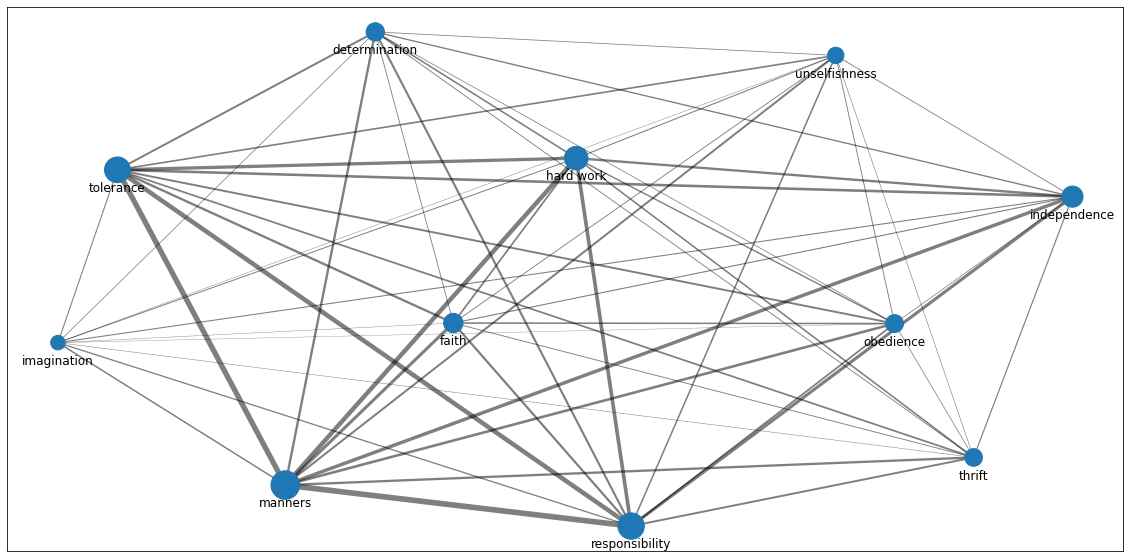

In [160]:
# Plot graph
plt.figure(figsize=(20,10))

nx.draw_networkx_edges(G, pos, edgelist=edges, width=width, alpha=0.5)
nx.draw_networkx_nodes(G, pos, nodelist=traits, node_size=size)
nx.draw_networkx_labels(G, label_pos, labels=labels)

plt.show()